In [73]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

from dlsia.core import helpers, train_scripts
from dlsia.core.networks import msdnet, tunet, tunet3plus
from dlsia.test_data.two_d import random_shapes
from dlsia.viz_tools import plots
from dlsia.core.train_scripts import segmentation_metrics

from tiled.client import from_uri
from tiled.client import show_logs, hide_logs
from tiled.utils import tree
from tiled.queries import FullText

hide_logs()

In [74]:
DATA_TILED_URI = os.getenv('DATA_TILED_URI')
DATA_TILED_API_KEY = os.getenv('DATA_TILED_API_KEY')
MASK_TILED_URI = os.getenv('MASK_TILED_URI')
MASK_TILED_API_KEY = os.getenv('MASK_TILED_API_KEY')

print(f'Cuda available? {torch.cuda.is_available()}')
print(f'# of GPUs: {torch.cuda.device_count()}')

Cuda available? False
# of GPUs: 0


In [75]:
class TiledDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            data_uri,
            mask_uri,
            data_api_key=None,
            mask_api_key=None,
            transform=None):
        '''
        Args:
            data_uri:       str, Tiled URI of data
            mask_uri:       str, Tiled URI of mask
            data_api_key:   str, Tiled API key for data access
            mask_api_key:   str, Tiled API key for mask access
            transform:      callable, if not given return PIL image

        Return:
            ml_data:        tuple, (data_tensor, mask_tensor)
        '''
        self.data_client = from_uri(data_uri, api_key=data_api_key)
        self.mask_client = from_uri(mask_uri, api_key=mask_api_key)
        self.list_indx = [10, 201, 222, 493]
        self.transform = transform

    def __len__(self):
        return len(self.mask_client)

    def __getitem__(self, idx):
        data = self.data_client[self.list_indx[idx],]
        #mask = self.mask_client[idx,]
        mask = self.mask_client[idx,].astype('int') # Conversion to int is needed as switching unlabeled pixels to -1 would cause trouble in uint8 format
        if self.transform:
            return self.transform(data), mask
        else:
            return data, mask

In [76]:
def train_segmentation(net, trainloader, validationloader, NUM_EPOCHS,
                       criterion, optimizer, device,
                       savepath=None, saveevery=None,
                       scheduler=None, show=0,
                       use_amp=False, clip_value=None):
    """
    Loop through epochs passing images to be segmented on a pixel-by-pixel
    basis.

    :param net: input network
    :param trainloader: data loader with training data
    :param validationloader: data loader with validation data
    :param NUM_EPOCHS: number of epochs
    :param criterion: target function
    :param optimizer: optimization engine
    :param device: the device where we calculate things
    :param savepath: filepath in which we save networks intermittently
    :param saveevery: integer n for saving network every n epochs
    :param scheduler: an optional schedular. can be None
    :param show: print stats every n-th epoch
    :param use_amp: use pytorch automatic mixed precision
    :param clip_value: value for gradient clipping. Can be None.
    :return: A network and run summary stats
    """

    train_loss = []
    F1_train_trace_micro = []
    F1_train_trace_macro = []

    # Skip validation steps if False or None loaded
    if validationloader is False:
        validationloader = None
    if validationloader is not None:
        validation_loss = []
        F1_validation_trace_micro = []
        F1_validation_trace_macro = []

    best_score = 1e10
    best_index = 0
    best_state_dict = None

    if savepath is not None:
        if saveevery is None:
            saveevery = 1

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        running_F1_train_micro = 0.0
        running_F1_train_macro = 0.0
        tot_train = 0.0

        if validationloader is not None:
            running_validation_loss = 0.0
            running_F1_validation_micro = 0.0
            running_F1_validation_macro = 0.0
            tot_val = 0.0
        count = 0

        for data in trainloader:
            count += 1
            noisy, target = data  # load noisy and target images
            N_train = noisy.shape[0]
            tot_train += N_train

            noisy = noisy.type(torch.FloatTensor)
            target = target.type(torch.LongTensor)
            noisy = noisy.to(device)
            target = target.to(device)

            if criterion.__class__.__name__ == 'CrossEntropyLoss':
                target = target.type(torch.LongTensor)
                target = target.to(device).squeeze(1)

            if use_amp is False:
                # forward pass, compute loss and accuracy
                output = net(noisy)
                loss = criterion(output, target)

                # backpropagation
                optimizer.zero_grad()
                loss.backward()
            else:
                scaler = torch.cuda.amp.GradScaler()
                with torch.cuda.amp.autocast():
                    # forward pass, compute loss and accuracy
                    output = net(noisy)
                    loss = criterion(output, target)

                # backpropagation
                optimizer.zero_grad()
                scaler.scale(loss).backward()

                # update the parameters
                scaler.step(optimizer)
                scaler.update()

            # update the parameters
            if clip_value is not None:
                torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)
            optimizer.step()


            tmp_micro, tmp_macro = segmentation_metrics(output, target)

            running_F1_train_micro += tmp_micro.item()
            running_F1_train_macro += tmp_macro.item()
            running_train_loss += loss.item()
        if scheduler is not None:
            scheduler.step()

        # compute validation step
        if validationloader is not None:
            with torch.no_grad():
                for x, y in validationloader:
                    x = x.to(device)
                    y = y.to(device)
                    N_val = y.shape[0]
                    tot_val += N_val
                    if criterion.__class__.__name__ == 'CrossEntropyLoss':
                        y = y.type(torch.LongTensor)
                        y = y.to(device).squeeze(1)

                    # forward pass, compute validation loss and accuracy
                    if use_amp is False:
                        yhat = net(x)
                        val_loss = criterion(yhat, y)
                    else:
                        with torch.cuda.amp.autocast():
                            yhat = net(x)
                            val_loss = criterion(yhat, y)

                    tmp_micro, tmp_macro = segmentation_metrics(yhat, y)
                    running_F1_validation_micro += tmp_micro.item()
                    running_F1_validation_macro += tmp_macro.item()

                    # update running validation loss and accuracy
                    running_validation_loss += val_loss.item()

        loss = running_train_loss / len(trainloader)
        F1_micro = running_F1_train_micro / len(trainloader)
        F1_macro = running_F1_train_macro / len(trainloader)
        train_loss.append(loss)
        F1_train_trace_micro.append(F1_micro)
        F1_train_trace_macro.append(F1_macro)

        if validationloader is not None:
            val_loss = running_validation_loss / len(validationloader)
            F1_val_micro = running_F1_validation_micro / len(validationloader)
            F1_val_macro = running_F1_validation_macro / len(validationloader)
            validation_loss.append(val_loss)
            F1_validation_trace_micro.append(F1_val_micro)
            F1_validation_trace_macro.append(F1_val_macro)
            # Update loss parquet file
            if epoch == 0:
                table = pd.DataFrame(
                    {
                        'epoch': [epoch],
                        'loss': [loss], 
                        'val_loss': [val_loss], 
                        'F1_micro': [F1_micro], 
                        'F1_macro': [F1_macro],
                        'F1_val_micro': [F1_val_micro],
                        'F1_val_macro': [F1_val_macro]
                    }
                    )
            else:
                table = pd.concat([
                    table, 
                    pd.DataFrame(
                        {
                        'epoch': [epoch],
                        'loss': [loss], 
                        'val_loss': [val_loss], 
                        'F1_micro': [F1_micro], 
                        'F1_macro': [F1_macro],
                        'F1_val_micro': [F1_val_micro],
                        'F1_val_macro': [F1_val_macro]
                        }
                    )
                ])
        else:
            # Update loss parquet file
            if epoch == 0:
                table = pd.DataFrame({
                        'epoch': [epoch],
                        'loss': [loss], 
                        'F1_micro': [F1_micro], 
                        'F1_macro': [F1_macro]})
            else:
                table = pd.concat([
                    table, 
                    pd.DataFrame(
                        {
                        'epoch': [epoch],
                        'loss': [loss], 
                        'F1_micro': [F1_micro], 
                        'F1_macro': [F1_macro]
                        }
                    )
                ])
        table.to_parquet(savepath+'/losses_per_epoch.parquet', engine='pyarrow')

        if show != 0:
            learning_rates = []
            for param_group in optimizer.param_groups:
                learning_rates.append(param_group['lr'])
            mean_learning_rate = np.mean(np.array(learning_rates))
            if np.mod(epoch + 1, show) == 0:
                if validationloader is not None:
                    print(
                        f'Epoch {epoch + 1} of {NUM_EPOCHS} | Learning rate {mean_learning_rate:4.3e}')
                    print(
                        f'   Training Loss: {loss:.4e} | Validation Loss: {val_loss:.4e}')
                    print(
                        f'   Micro Training F1: {F1_micro:.4f} | Micro Validation F1: {F1_val_micro:.4f}')
                    print(
                        f'   Macro Training F1: {F1_macro:.4f} | Macro Validation F1: {F1_val_macro:.4f}')
                else:
                    print(
                        f'Epoch {epoch + 1} of {NUM_EPOCHS} | Learning rate {mean_learning_rate:4.3e}')
                    print(
                        f'   Training Loss: {loss:.4e} | Micro Training F1: {F1_micro:.4f} | Macro Training F1: {F1_macro:.4f}')

        if validationloader is not None:
            if val_loss < best_score:
                best_state_dict = net.state_dict()
                best_index = epoch
                best_score = val_loss
        else:
            if loss < best_score:
                best_state_dict = net.state_dict()
                best_index = epoch
                best_score = loss

            if savepath is not None:
                torch.save(best_state_dict, savepath + '/net_best')
                print('   Best network found and saved')
                print('')

        if savepath is not None:
            if np.mod(epoch + 1, saveevery) == 0:
                torch.save(net.state_dict(), savepath + '/net_checkpoint')
                print('   Network intermittently saved')
                print('')

    if validationloader is None:
        validation_loss = None
        F1_validation_trace_micro = None
        F1_validation_trace_macro = None

    results = {"Training loss": train_loss,
               "Validation loss": validation_loss,
               "F1 training micro": F1_train_trace_micro,
               "F1 training macro": F1_train_trace_macro,
               "F1 validation micro": F1_validation_trace_micro,
               "F1 validation macro": F1_validation_trace_macro,
               "Best model index": best_index}

    net.load_state_dict(best_state_dict)
    return net, results

In [77]:
data_transform = transforms.ToTensor()

dataset = TiledDataset(
    data_uri=DATA_TILED_URI,
    mask_uri=MASK_TILED_URI,
    data_api_key=DATA_TILED_API_KEY,
    mask_api_key=MASK_TILED_API_KEY,
    transform=data_transform
    )

## Dataset simple test

In [78]:
start = time.time()
sample = next(iter(dataset))
print(f'Elapsed time: {time.time() - start}')

x = sample[0]
mask_x = sample[1]

print(x.shape)
print(mask_x.shape)

Elapsed time: 0.5118536949157715
torch.Size([1, 1760, 1760])
(1760, 1760)


In [79]:
dataset[0]

(tensor([[[0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
          [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
          [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
          ...,
          [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
          [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
          [0.2510, 0.2510, 0.2510,  ..., 0.2510, 0.2510, 0.2510]]]),
 array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]]))

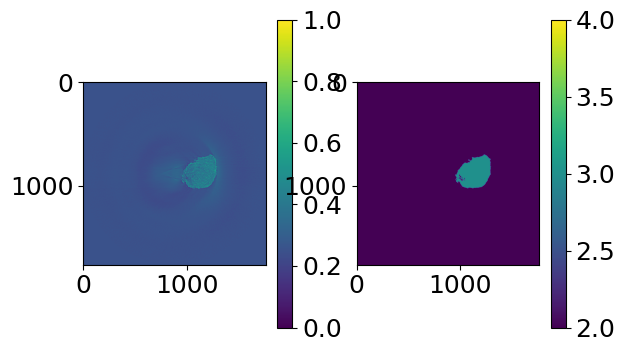

In [80]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10, 4))
plt.subplot(131)
plt.imshow(x[0])
plt.colorbar()

plt.subplot(132)
plt.imshow(mask_x)
plt.colorbar()

# plt.subplot(133)
# plt.imshow(np.squeeze(x[0]))
# plt.show()

#print(np.unique(raw_stack[0]))

In [81]:
np.unique(mask_x)

array([2, 3, 4])

## Training parameters

In [82]:
# Train Val Split
val_pct = 0.2

# Specify batch sizes
batch_size_train = 1
batch_size_val = 1
batch_size_test = 1

# Dataset shape
data_shape = np.array(dataset.data_client.shape)
if len(data_shape)==3:
    in_channels = 1
    image_shape = data_shape[1:]
else:
    in_channels = data_shape[1]
    image_shape = data_shape[2:]
out_channels = 3
depth = 4 #<6
base_channels = 16 # 8 16 32
growth_rate = 2
hidden_rate = 1
activation = nn.ReLU()
normalization = nn.BatchNorm2d  # Change to 3d for volumous data

# Training Parameters
epochs = 3
learning_rate = 1e-2

In [83]:
# Set Dataloader parameters (Note: we randomly shuffle the training set upon each pass)
train_loader_params = {'batch_size': batch_size_train,
                       'shuffle': True}
val_loader_params = {'batch_size': batch_size_val,
                       'shuffle': True}
# Set Dataloader parameters (Note: we randomly shuffle the training set upon each pass)
test_loader_params = {'batch_size': batch_size_test,
                      'shuffle': False}


# Build Dataloaders
val_size = int(val_pct*len(dataset))
if len(dataset) == 1:
    train_loader = DataLoader(dataset, **train_loader_params)
    val_loader = None
elif val_size == 0:
    train_size = len(dataset) - 1
    train_data, val_data = random_split(dataset, [train_size, 1])
    train_loader = DataLoader(train_data, **train_loader_params)
    val_loader = DataLoader(val_data, **val_loader_params)
else:
    train_size = len(dataset) - val_size
    train_data, val_data = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_data, **train_loader_params)
    val_loader = DataLoader(val_data, **val_loader_params)

# Build Dataloaders
test_loader = DataLoader(dataset, **test_loader_params)

print("The length of train data is:",len(train_data))
print("The length of validation data is:",len(val_data))
print("The length of test data is:",len(dataset))

The length of train data is: 3
The length of validation data is: 1
The length of test data is: 4


In [84]:
# Save Paths
model_dir_path = f'models/'
save_tunet_path = model_dir_path + f'tunet_d{depth}-b{base_channels}-g{growth_rate}-h{hidden_rate}.pt'

In [85]:
tunet_model = tunet.TUNet(image_shape=image_shape,
                          in_channels=in_channels,
                          out_channels=out_channels,
                          depth=depth,
                          base_channels=base_channels,
                          growth_rate=growth_rate,
                          hidden_rate=hidden_rate,
                          activation=activation,
                          normalization=normalization,
                         )

print('Number of parameters: ', helpers.count_parameters(tunet_model))

Number of parameters:  483187


In [86]:
label2ignore = -1
criterion = getattr(nn, "CrossEntropyLoss")
criterion = criterion(ignore_index=label2ignore, size_average=None)

# Define optimizers, one per network
optimizer_tunet = optim.Adam(tunet_model.parameters(), lr=learning_rate)

device = helpers.get_device()
print('Device we will compute on: ', device)   # cuda:0 for GPU. Else, CPU

Device we will compute on:  cpu


In [87]:
np.unique(train_data[0][1])

array([2, 3, 4])

In [88]:
tunet_model.to(device)   # send network to GPU

tunet_model, results = train_segmentation(tunet_model,
                                          train_loader,
                                          val_loader,
                                          epochs,
                                          criterion,
                                          optimizer_tunet,
                                          device,
                                          show=5,
                                          savepath='models'
                                          )   # training happens here
tunet_model = tunet_model.cpu()

fig = plots.plot_training_results_segmentation(results)
plt.figure(dpi=20)
fig.show()

# Save Model
tunet_model.save_network_parameters(save_tunet_path)

# clear out unnecessary variables from device (GPU) memory
torch.cuda.empty_cache()

IndexError: Target 3 is out of bounds.

## Prediction step

Image 0


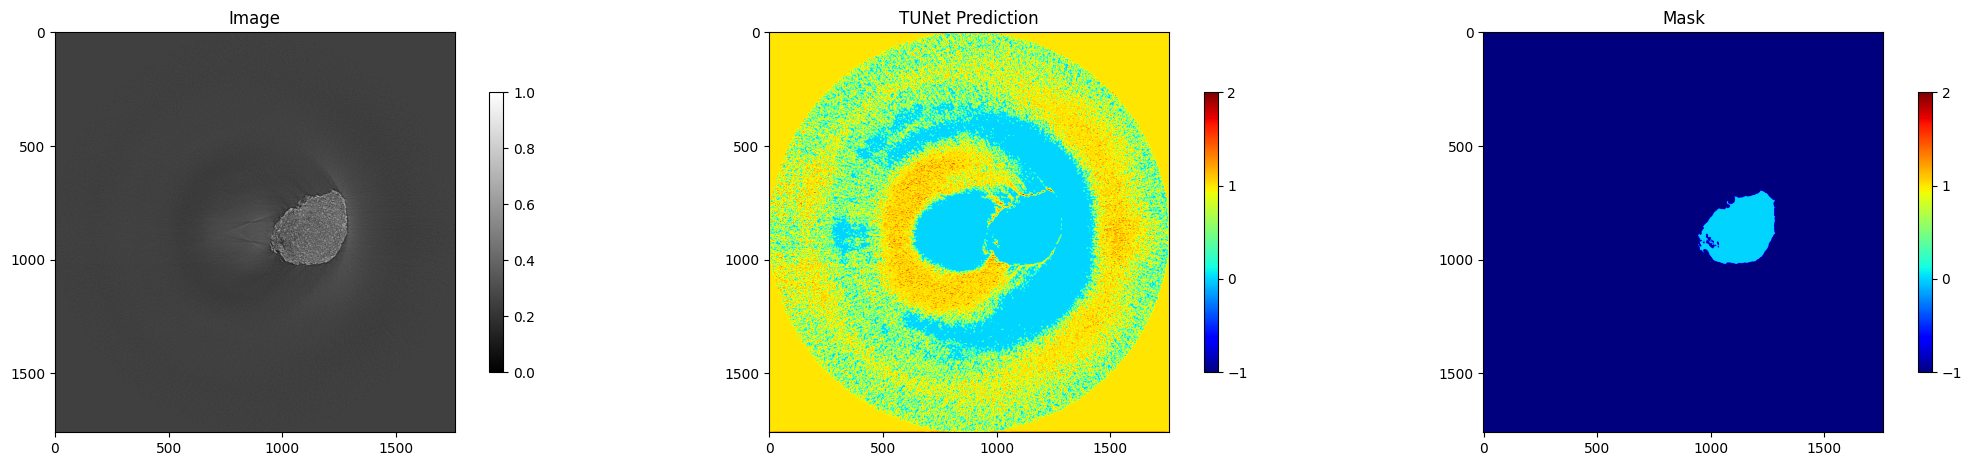

<Figure size 128x96 with 0 Axes>

Image 0


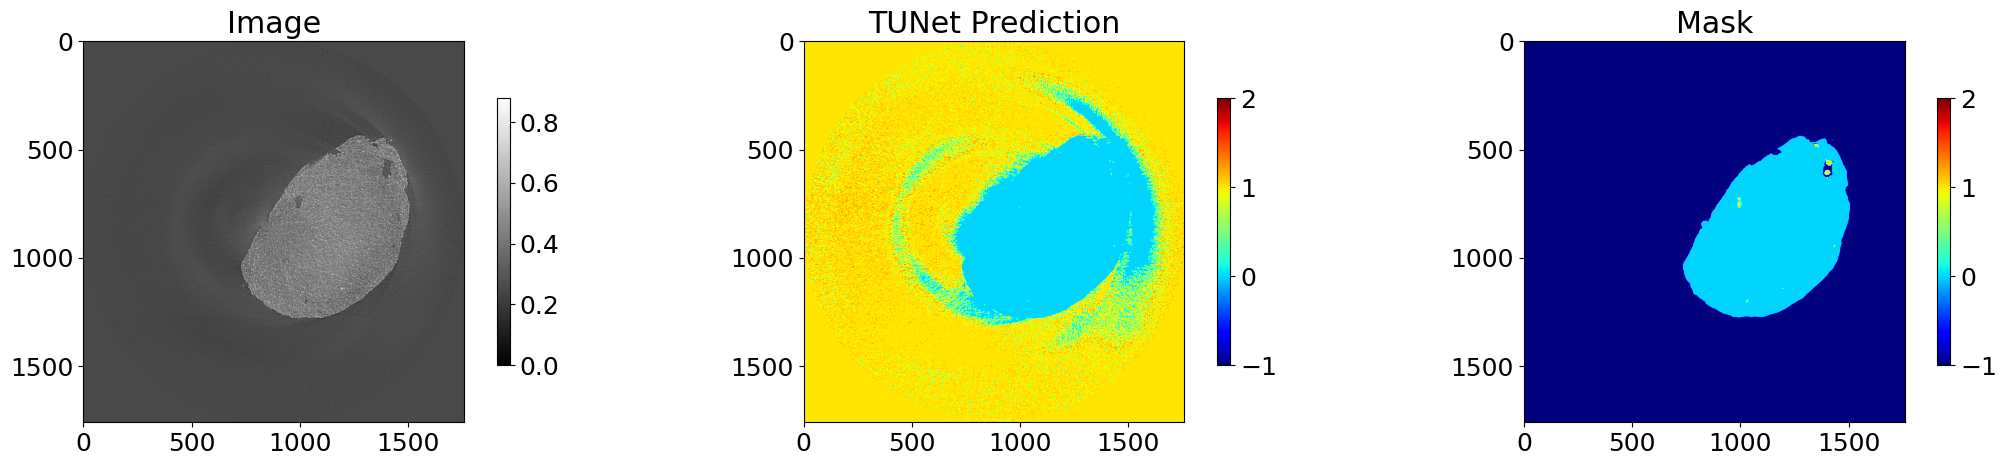

<Figure size 128x96 with 0 Axes>

Image 0


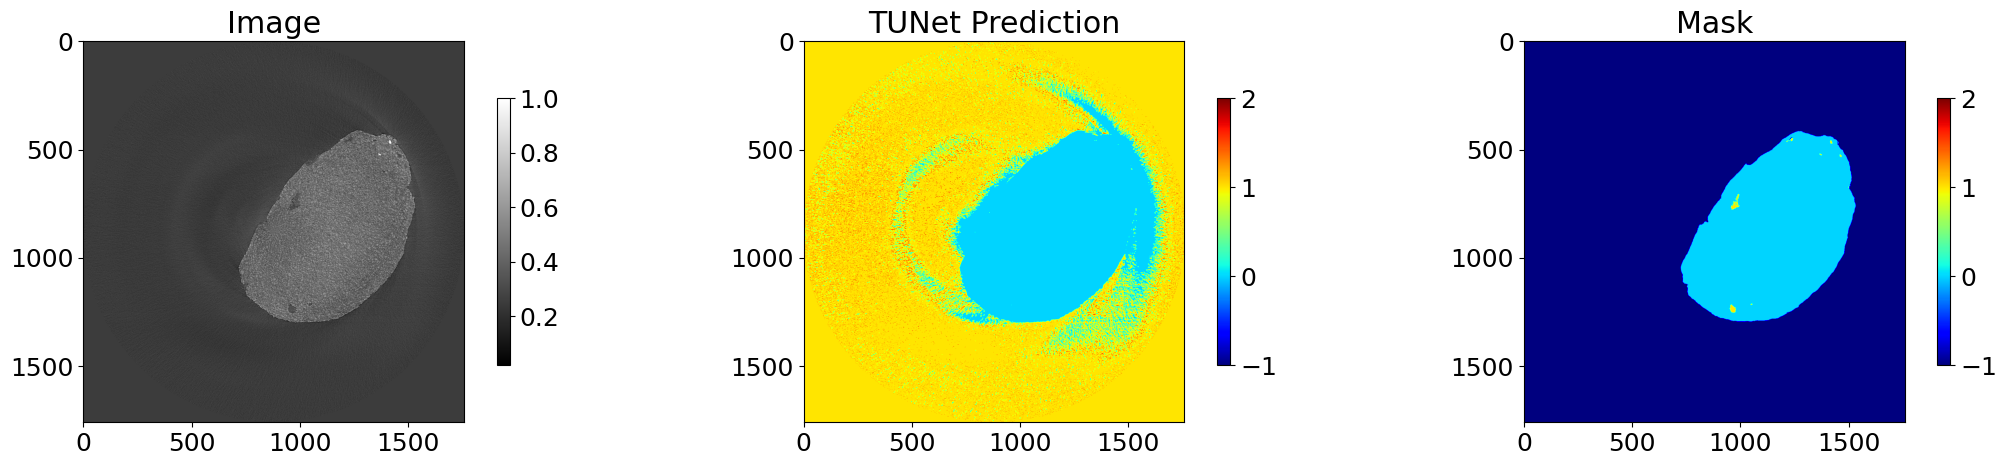

<Figure size 128x96 with 0 Axes>

Image 0


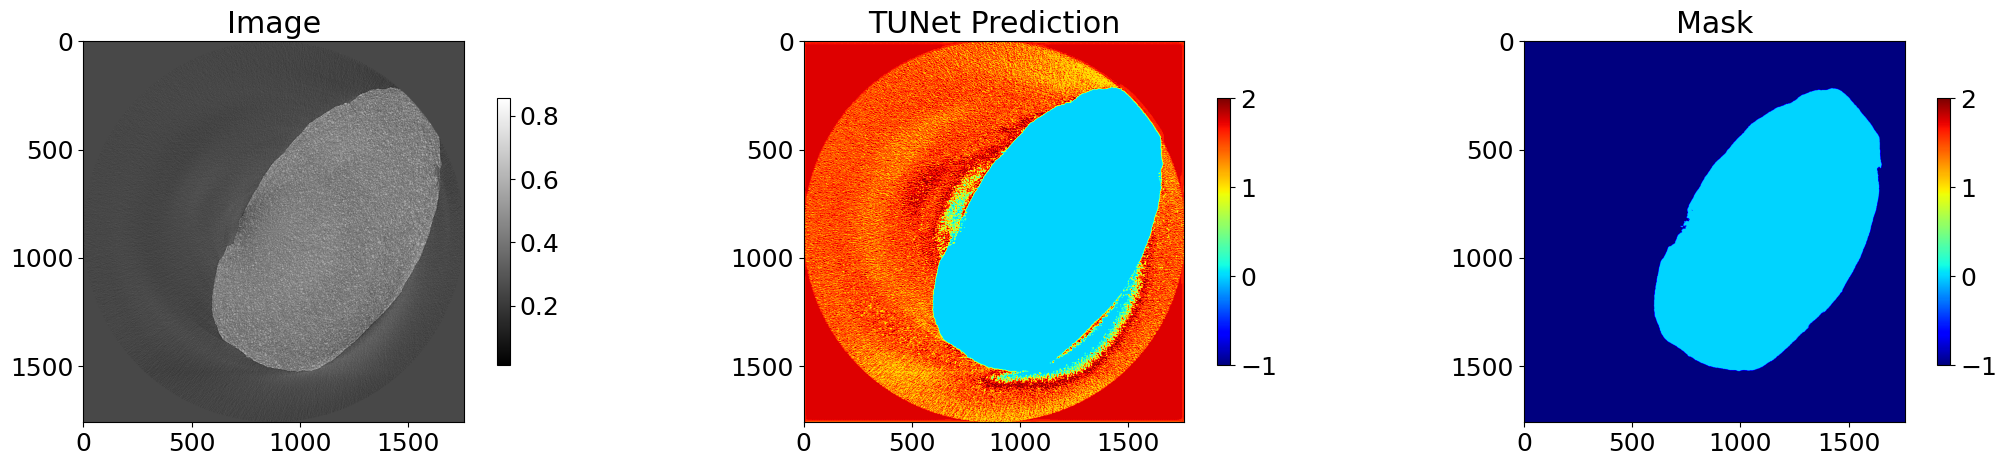

<Figure size 128x96 with 0 Axes>

In [ ]:
tunet_model.to(device)   # send network to GPU
n = 0
cmap='jet'
for batch in test_loader:
    with torch.no_grad():
        data, mask = batch
        # Necessary data recasting
        data = data.type(torch.FloatTensor)
        mask = mask.type(torch.LongTensor)
        data = data.to(device)
        mask = mask.to(device)#.squeeze(1)

        # Input passed through networks here
        output_tunet = tunet_model(data)
        # Individual output passed through argmax to get predictions
        preds_tunet = torch.argmax(output_tunet.cpu().data, dim=1)
        torch.save(preds_tunet, save_tunet_path + f'preds_tunet-batch{n}.pt')
        
        n += 1
        shrink=0.7
        for j in range(len(data)):
            print(f'Image {j}')
            plt.figure(figsize=(22,5))

            # Display data input
            plt.subplot(131)
            plt.imshow(data.cpu()[j,0,...].data, cmap = 'gray')
            plt.colorbar(shrink=shrink)
            plt.title('Image')

            # Display tunet predictions
            plt.subplot(132)
            plt.imshow(preds_tunet[j,...], cmap=cmap)
            plt.colorbar(shrink=shrink)
            plt.clim(-1,2)
            plt.title('TUNet Prediction')

            # Display masks/ground truth
            plt.subplot(133)
            plt.imshow(mask.cpu()[j,...], cmap=cmap)
            plt.colorbar(shrink=shrink)
            plt.title('Mask')
            plt.clim(-1,2)
            plt.rcParams.update({'font.size': 18})
            plt.tight_layout()

            plt.figure(dpi=20)
            plt.show()

        
# clear out unnecessary variables from device (GPU) memory
torch.cuda.empty_cache()